# Предсказание вероятности дефолта клиента банка
Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

**Цель**: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

# import

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

import os

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
data = pd.read_csv(
    '/Users/dariamishina/Documents/Skillfactory/skillfactory_rds/module_4/train.csv')
true_test = pd.read_csv(
    '/Users/dariamishina/Documents/Skillfactory/skillfactory_rds/module_4/test.csv')
sample_submission = pd.read_csv(
    '/Users/dariamishina/Documents/Skillfactory/skillfactory_rds/module_4/sample_submission.csv')

In [6]:
# посмотрим на типы данных и количество пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Подробнее по признакам:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

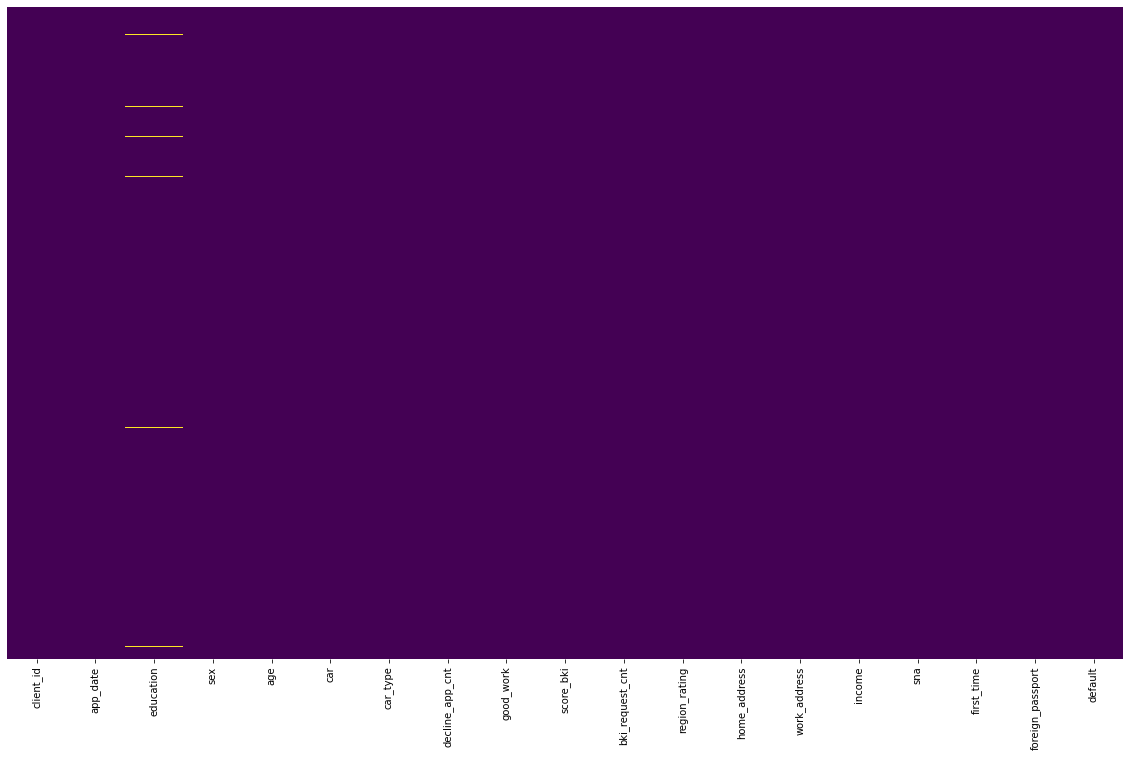

In [4]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**Целевая переменная (default)** - без пропусков

**Признаки c пропусками:**
* education

**Бинарные переменные:**
* sex
* car
* car_type
* foreign_passport
* good_work

**Категориальные переменные:**
* education
* work_address
* home_address
* sna
* first_time
* region_rating
* app_date (содержит в себе дату обращения, для использования надо распарсить, кодировать через OneHotEncoder не имеет смысла)

**Числовые переменные:**
* age
* decline_app_cnt
* income
* bki_request_cnt
* score_bki

In [5]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
11167,326,03JAN2014,GRD,M,55,Y,Y,0,0,-2.167701,1,40,3,3,150000,1,3,N,0
42668,41475,18FEB2014,GRD,M,27,Y,Y,2,1,-1.031897,3,50,2,3,45000,1,4,Y,0
32305,29677,05FEB2014,SCH,M,35,Y,Y,0,1,-1.485710,0,60,2,3,50000,4,3,N,0
25554,97585,14APR2014,SCH,F,42,N,N,0,0,-2.538195,1,50,2,3,30000,1,4,N,0
25678,101194,18APR2014,GRD,M,59,N,N,0,0,-1.892157,3,80,2,3,35000,1,4,N,0


Как видим, большинство признаков у нас без пропусков, и датасет не требует значительной очистки и предварительной обработки

Посмотрим, каких клиентов у банка больше: дефолтных или добросовестных 

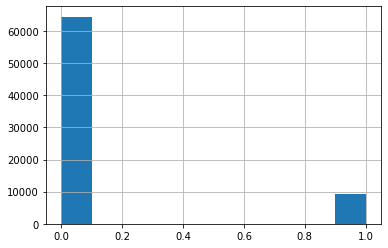

In [6]:
data.default.hist();

у банка большинство клиентов добросовестные, выборка не слишком сбалансирована, в дальнейшем попробуем поэксперементировать с гиперпараметром class_weight для логистической регрессии

# Cleaning and Prepping Data

## Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   

в датасете всего один признак с пропусками, посмотрим, сколько их и стоит ли перед обработкой NAN вынести информацию о наличии пропуска как отдельный признак 

In [7]:
data.education.value_counts(dropna=False, normalize=True)

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
NaN    0.004160
ACD    0.002629
Name: education, dtype: float64

так как пропусков меньше 1%, то не будем делать отдельный признак отсутствия информации, а просто заполним пропуски самым часто встречающимся значением, то есть SCH

In [7]:
data['education'] = data['education'].fillna(data['education'].mode()[0])

# EDA

## Распределение числовых данных:

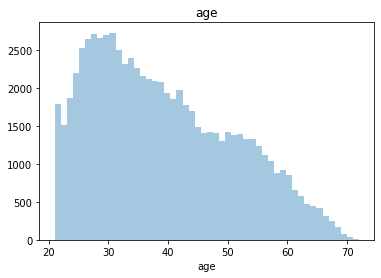

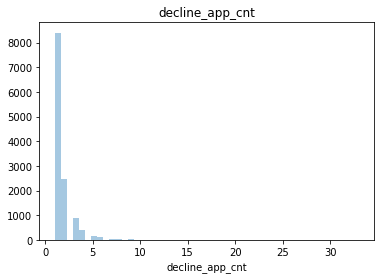

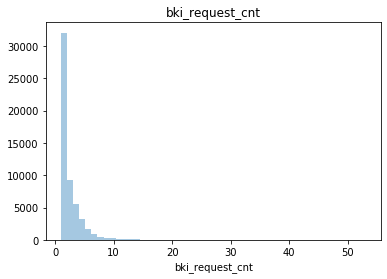

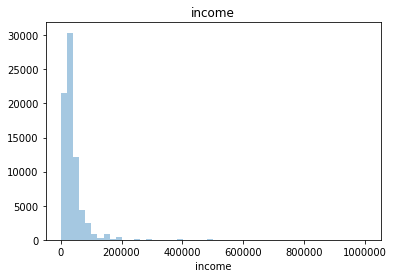

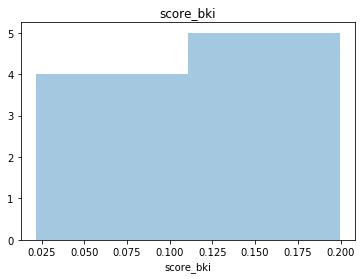

In [8]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

странно выглядит распределение признака score_bki, выведем его отдельно

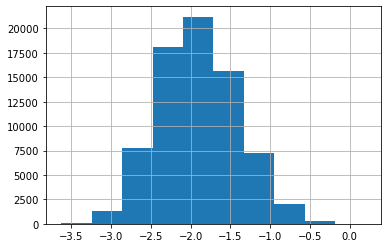

In [219]:
data.score_bki.hist();

как оказалось, все дело в фильтре [data[i] > 0].dropna(), который отбрасывает все значения меньше 0, а признак score_bki может быть как положительным, так и отрицательным. Уберем его и посмотрим еще раз на распределение

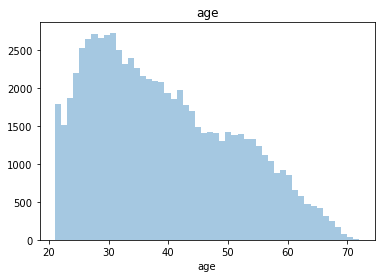

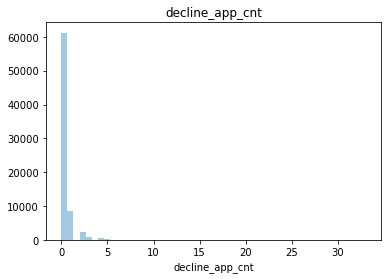

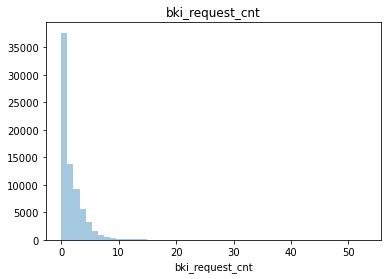

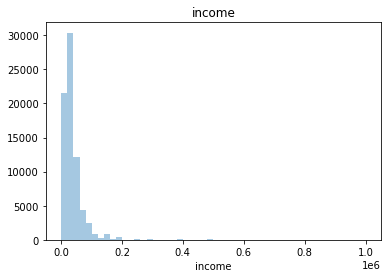

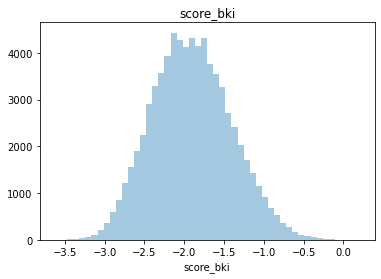

In [220]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Судя по данным из официальной документации https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html для age - хи квадратное распределение, для decline_app_cnt, bki_request_cnt, income - логнормальное распределение, для score_bki - нормальное распределение

Будем по очереди пробовать разные способы превращения распределения в нормальное:

1) логарифмирование для логнормально распределенных признаков

2) преобразование Бокса-Кокса (для признаков, значения ктр строго больше 0)

3) преобразование Йео-Джонсона

4) квантильное преобразование

### Логарифмирование

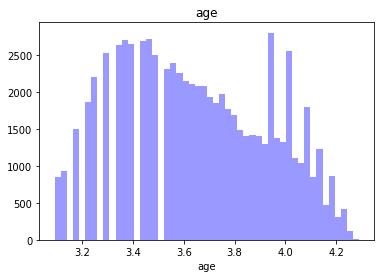

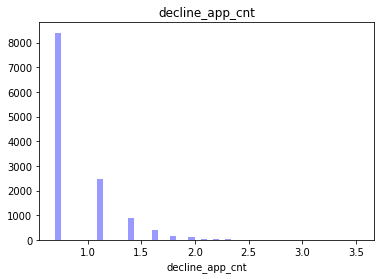

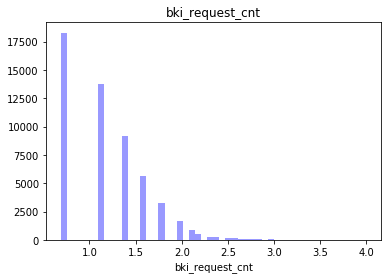

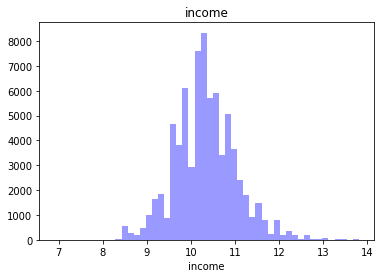

In [9]:
# числовые переменные, которые будем логарифмировать, все кроме 'score_bki', у ктр и так нормальное распределение
log_num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in log_num_cols:
    #зачем к логарифму добавляем 1 - чтобы если в df[i] был 0, то натуральный логарифм нуля - минус бесконечность
    data[i] = np.log(data[i]+1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

__проверим, что получилось еще раз и перезапишем список с числовыми данными__

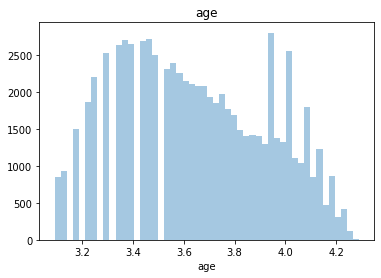

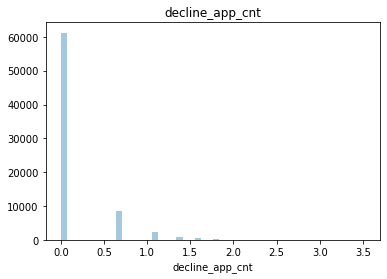

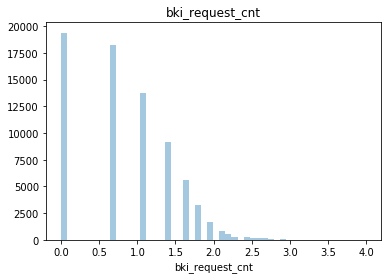

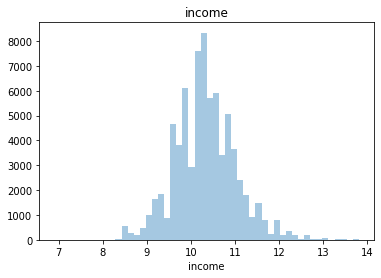

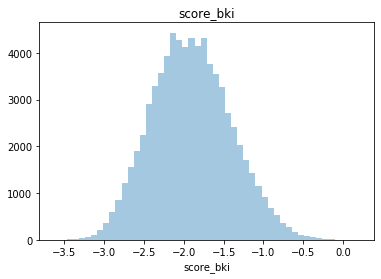

In [10]:
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

__видимый результат только для признака income__

### Преобразование Бокса-Кокса

преобразование Бокса-Кокса может быть применено к строго положительным значениям, а значит не подойдет для decline_app_cnt и bki_request_cnt, опробуем его на признаках age и  income

In [131]:
data['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

In [132]:
data['bki_request_cnt'].value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
28        4
22        4
32        2
27        2
26        2
25        2
46        1
29        1
33        1
34        1
36        1
41        1
45        1
53        1
Name: bki_request_cnt, dtype: int64

In [133]:
data['age'].value_counts()

31    2727
28    2705
30    2693
29    2659
27    2645
26    2528
32    2501
34    2395
33    2314
35    2259
25    2202
36    2159
37    2118
38    2088
39    2082
42    1973
40    1932
24    1873
41    1857
43    1770
44    1690
23    1509
45    1487
50    1424
47    1418
46    1407
48    1404
52    1387
51    1385
53    1326
54    1326
49    1304
55    1230
56    1114
57    1040
22     937
59     925
58     881
60     851
21     849
61     661
62     576
63     477
64     449
65     422
66     309
67     248
68     165
69      81
70      32
71       3
72       2
Name: age, dtype: int64

In [134]:
data['income'].value_counts()

30000     7009
25000     6061
20000     5471
40000     4935
50000     4470
          ... 
37600        1
27350        1
27478        1
53800        1
426000       1
Name: income, Length: 966, dtype: int64

In [ ]:
bc = PowerTransformer(method='box-cox')
df1 = data['income'].values.reshape(1,-1)
bc.fit(df1)
bc.transform(df1)

In [ ]:
bc = PowerTransformer(method='box-cox')
df4 = data['age'].values.reshape(1,-1)
bc.fit(df4)
bc.transform(df4)

### Преобразование Йео-Джонсона

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBD2F36708>]],
      dtype=object)

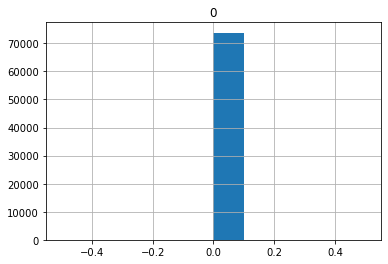

In [138]:
yj = PowerTransformer(method='yeo-johnson')
df5 = data['age'].values.reshape(1,-1)
yj.fit(df5)
yj.transform(df5)
e = yj.transform(df5).reshape((73799, 1))
f = pd.DataFrame(e)
f.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CA6CC24C8>]],
      dtype=object)

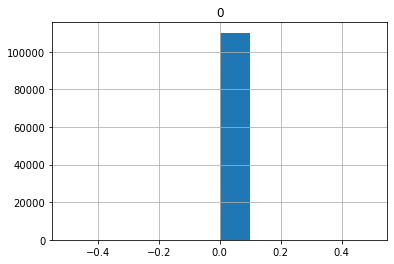

In [110]:
yj = PowerTransformer(method='yeo-johnson')
df6 = data['decline_app_cnt'].values.reshape(1,-1)
yj.fit(df6)
yj.transform(df6)
g = yj.transform(df6).reshape((73799, 1))
h = pd.DataFrame(g)
h.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CA6D9CC88>]],
      dtype=object)

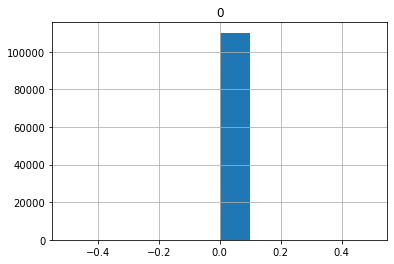

In [112]:
yj = PowerTransformer(method='yeo-johnson')
df7 = data['bki_request_cnt'].values.reshape(1,-1)
yj.fit(df7)
yj.transform(df7)
i = yj.transform(df7).reshape((73799, 1))
j = pd.DataFrame(i)
j.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CDD17EC48>]],
      dtype=object)

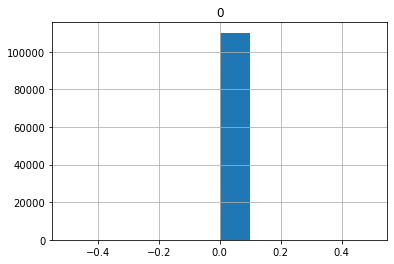

In [128]:
yj = PowerTransformer(method='yeo-johnson')
df2 = data['income'].values.reshape(1,-1)
yj.fit(df2)
yj.transform(df2)
a = yj.transform(df2).reshape((73799, 1))
b = pd.DataFrame(a)
b.hist()

### Квантильное преобразование

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (1). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CA6D1E108>]],
      dtype=object)

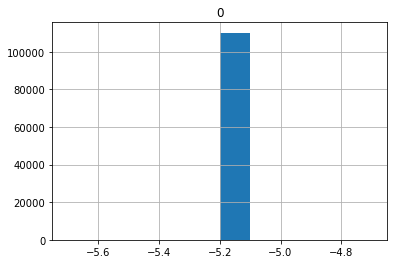

In [111]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df8 = data['age'].values.reshape(1,-1)
qt.fit(df8)
qt.transform(df8)
k = qt.transform(df8).reshape((73799, 1))
l = pd.DataFrame(k)
l.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (1). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CA6E15F08>]],
      dtype=object)

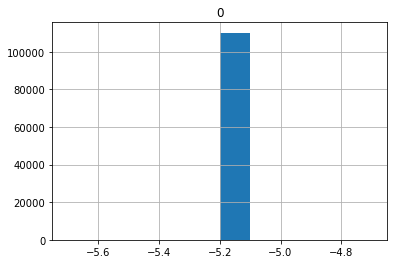

In [113]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df9 = data['decline_app_cnt'].values.reshape(1,-1)
qt.fit(df9)
qt.transform(df9)
m = qt.transform(df9).reshape((73799, 1))
n = pd.DataFrame(m)
n.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (1). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CA83A7B88>]],
      dtype=object)

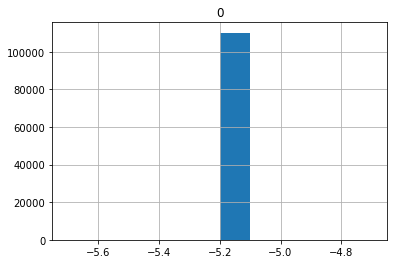

In [114]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df10 = data['bki_request_cnt'].values.reshape(1,-1)
qt.fit(df10)
qt.transform(df10)
o = qt.transform(df10).reshape((73799, 1))
p = pd.DataFrame(o)
p.hist()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (1). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBD2F362C8>]],
      dtype=object)

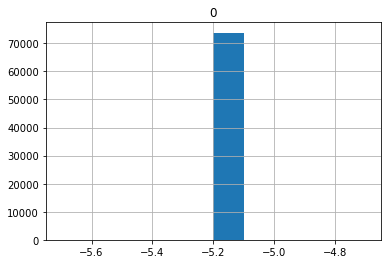

In [141]:
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df3 = data['income'].values.reshape(1,-1)
qt.fit(df3)
qt.transform(df3)
c = qt.transform(df3).reshape((73799, 1))
d = pd.DataFrame(c)
d.hist()

Попытки сделать распределения числовых признаков нормальными не слишком успешны. Только признак income после логарифмирования показывает нормальное распределение. Преобразование Бокса-Кокса даже для признаков income и age, значения ктр строго больше 0, не удалось сделать. Преобразование Йео-Джонсона и квантильное преобразование не привели к тому, что распределения стали нормальными. Поэтому остановимся на логарифмировании

__Но вообще такая ситуация не очень хороша, потому что для однофакторного дисперсионный анализ (ANOVA) и  t-тестов распределение должно быть нормальным__

## Выбросы

посмотрим на выбросы для числовых переменных по очереди

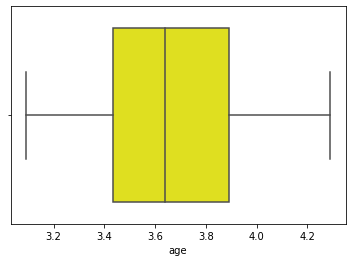

In [11]:
sns.boxplot(data.age, color='yellow');

у этого признака выбросов нет

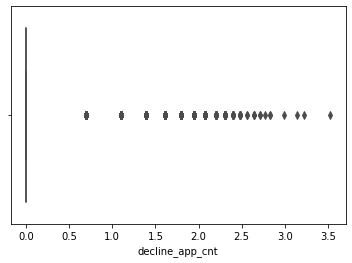

In [12]:
sns.boxplot(data.decline_app_cnt, color='yellow');

На графике видно, что выбросы есть. Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами коробки. Посмотрим, сколько выбросов он найдет:

In [13]:
def outliers_iqr(ys):
    #находим квартили
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    #находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    #нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    #верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)
    #возращаем только те значения и их индексы, ктр больше upper_bound и меньше lower_bound
    return ys[((ys > upper_bound) | (ys < lower_bound))]

In [14]:
#применяем функцию к колонке data.decline_app_cnt
out = outliers_iqr(data.decline_app_cnt)
out

2        1.098612
8        0.693147
10       1.098612
33       1.098612
38       0.693147
           ...   
73757    1.098612
73762    0.693147
73771    1.386294
73776    1.609438
73782    1.098612
Name: decline_app_cnt, Length: 12585, dtype: float64

In [11]:
len(out)/len(data)

0.17053076599953929

Выбросов более 17%, выбрасывать такое количество данных нецелесообразно. Попробуем в дальнейшем решить этот вопрос с помощью скейлеров

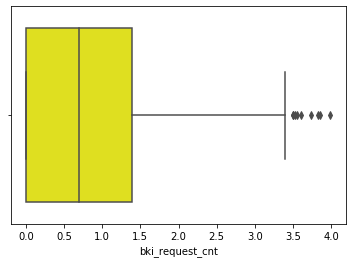

In [15]:
sns.boxplot(data.bki_request_cnt, color='yellow');

In [16]:
#применяем функцию к колонке data.bki_request_cnt
out1 = outliers_iqr(data.bki_request_cnt)
out1

655      3.555348
8944     3.496508
19275    3.496508
25661    3.610918
27639    3.988984
33206    3.828641
39719    3.526361
55405    3.737670
67718    3.850148
Name: bki_request_cnt, dtype: float64

In [17]:
len(out1)/len(data)

0.00012195287199013537

Выбросов менее 1%, удалим их

In [18]:
#находим квартили
quartile_1, quartile_3 = np.percentile(data.bki_request_cnt, [25, 75])
#находим межквартильное расстояние
iqr = quartile_3 - quartile_1
#нижняя граница коробки
lower_bound = quartile_1 - (iqr * 1.5)
#верхняя граница коробки
upper_bound = quartile_3 + (iqr * 1.5)

#Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:
data = data.loc[data.bki_request_cnt.between(lower_bound, upper_bound)]

Проверяем, что получилось в итоге:

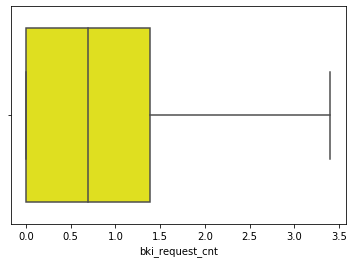

In [19]:
sns.boxplot(data.bki_request_cnt, color='yellow');

Теперь выбросов и для этого признака нет

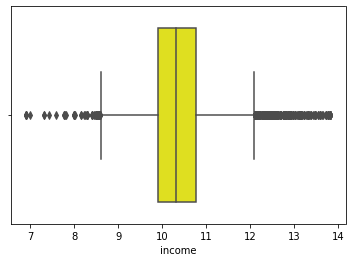

In [20]:
sns.boxplot(data.income, color='yellow');

In [21]:
#применяем функцию к колонке data.income
out2 = outliers_iqr(data.income)
out2

54       12.206078
72       12.765691
94        8.517393
101       8.517393
176       8.517393
           ...    
73562    12.429220
73569    12.100718
73579     8.594339
73731    12.206078
73740    12.206078
Name: income, Length: 1770, dtype: float64

In [22]:
len(out2)/len(data)

0.02398699010706058

Выбросов около 2%, удалим их

In [23]:
#находим квартили
quartile_1, quartile_3 = np.percentile(data.income, [25, 75])
#находим межквартильное расстояние
iqr = quartile_3 - quartile_1
#нижняя граница коробки
lower_bound = quartile_1 - (iqr * 1.5)
#верхняя граница коробки
upper_bound = quartile_3 + (iqr * 1.5)

#Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:
data = data.loc[data.income.between(lower_bound, upper_bound)]

проверим, что получилось в итоге

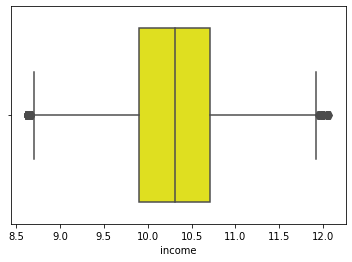

In [24]:
sns.boxplot(data.income, color='yellow');

Выбросы снова есть, проверим сколько их и проделаем поиск и удаление выбросов еще раз

In [25]:
#применяем функцию к колонке data.income 
out3 = outliers_iqr(data.income)
out3

189      11.982935
600      11.982935
1323     11.957618
1562      8.612685
2270     12.043560
           ...    
72948    11.982935
73025     8.612685
73212    11.982935
73364    12.081761
73755     8.665786
Name: income, Length: 263, dtype: float64

In [23]:
len(out3)/len(data)

0.0036517633990558176

In [26]:
#находим квартили
quartile_1, quartile_3 = np.percentile(data.income, [25, 75])
#находим межквартильное расстояние
iqr = quartile_3 - quartile_1
#нижняя граница коробки
lower_bound = quartile_1 - (iqr * 1.5)
#верхняя граница коробки
upper_bound = quartile_3 + (iqr * 1.5)

#Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:
data = data.loc[data.income.between(lower_bound, upper_bound)]

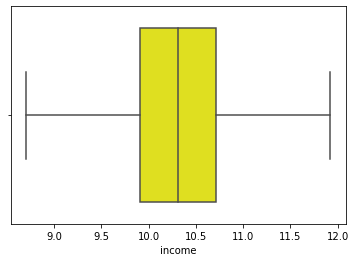

In [27]:
sns.boxplot(data.income, color='yellow');

Теперь в этом признаке выбросов нет

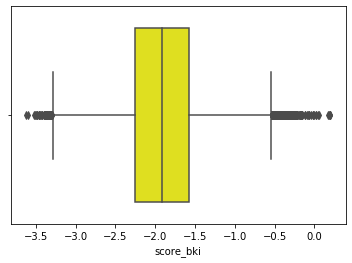

In [28]:
sns.boxplot(data.score_bki, color='yellow');

In [29]:
#применяем функцию к колонке data.score_bki
out4 = outliers_iqr(data.score_bki)
out4

56      -0.500103
80      -0.266137
235     -0.275273
429     -0.523215
446     -0.523830
           ...   
72993   -0.012303
73265   -0.470095
73367   -0.281990
73478   -3.395724
73644   -0.459329
Name: score_bki, Length: 336, dtype: float64

In [30]:
len(out4)/len(data)

0.004682470002926544

Количество выбросов менее 1%, избавимся от них

In [31]:
#находим квартили
quartile_1, quartile_3 = np.percentile(data.score_bki, [25, 75])
#находим межквартильное расстояние
iqr = quartile_3 - quartile_1
#нижняя граница коробки
lower_bound = quartile_1 - (iqr * 1.5)
#верхняя граница коробки
upper_bound = quartile_3 + (iqr * 1.5)

#Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:
data = data.loc[data.score_bki.between(lower_bound, upper_bound)]

Проверяем, что получилось

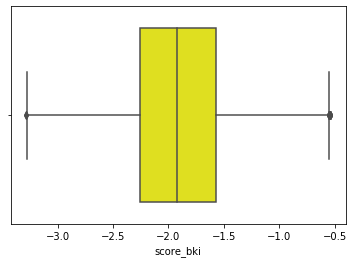

In [32]:
sns.boxplot(data.score_bki, color='yellow');

In [33]:
#применяем функцию к колонке data.score_bki еще раз
out5 = outliers_iqr(data.score_bki)
out5

5682    -0.547986
9772    -0.547376
15097   -0.548095
16697   -0.544025
17044   -0.546546
20808   -0.541518
26300   -0.539844
26552   -0.542153
26903   -0.541268
30089   -0.541312
34198   -0.550991
34453   -0.548332
49086   -0.546465
53412   -0.546711
54646   -3.283852
57003   -0.550770
57866   -0.544203
62651   -0.549427
63963   -0.549605
64544   -0.544930
70423   -0.543941
71002   -3.286750
Name: score_bki, dtype: float64

In [34]:
len(out5)/len(data)

0.0003080326514610549

In [35]:
#находим квартили
quartile_1, quartile_3 = np.percentile(data.score_bki, [25, 75])
#находим межквартильное расстояние
iqr = quartile_3 - quartile_1
#нижняя граница коробки
lower_bound = quartile_1 - (iqr * 1.5)
#верхняя граница коробки
upper_bound = quartile_3 + (iqr * 1.5)

#Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:
data = data.loc[data.score_bki.between(lower_bound, upper_bound)]

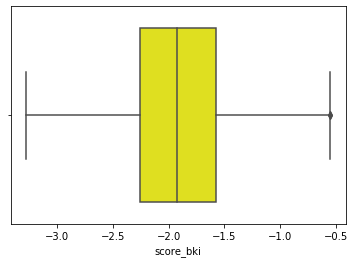

In [36]:
sns.boxplot(data.score_bki, color='yellow')

Теперь у этого признака нет выбросов

In [37]:
len(data)

71399

Длина датасета сократилась до 71399, но зато мы избавились почти ото всех выбросов, кроме выбросов для признака decline_app_cnt из-за их значительного количества

# Оценка корреляций

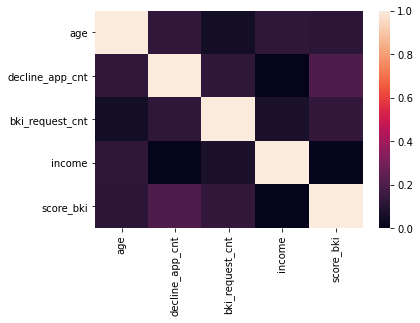

In [187]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)
#annot=True этот параметр отвечает за вывод значения на карту
#sns.heatmap(stud_for_corr.corr(), square=True, annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

In [188]:
data[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income,score_bki
age,1.000000,-0.129297,0.047977,-0.122273,-0.114397
decline_app_cnt,-0.129297,1.000000,0.122074,-0.006899,0.205623
bki_request_cnt,0.047977,0.122074,1.000000,0.071242,0.133122
income,-0.122273,-0.006899,0.071242,1.000000,0.008039
score_bki,-0.114397,0.205623,0.133122,0.008039,1.000000


Взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент 0.205623. Мультиколлинеарность отсутствует, оставляем все числовые признаки для модели

# Значимость непрерывных переменных

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

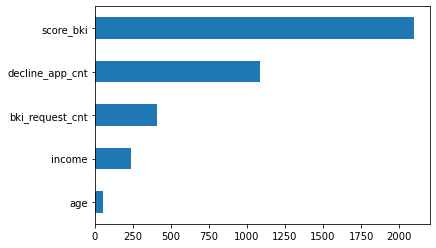

In [249]:
#df[num_cols] - это признаки
#df['default'] - это таргет 
#index = num_cols - а так присваиваются названия признакам, но это именно для сериз
#указываем индекс [0], чтобы выводились значения
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
#сортировка по убыванию
imp_num.sort_values(inplace = True)
#barh - для переворачивания гистограммы
imp_num.plot(kind = 'barh')

Исходя из значений f-статистики для числовых признаков можно сделать вывод, что score_bki, decline_app_cnt и bki_request_cnt являются достаточно важными признаками, а income и age такими не являются. __Будем помнить об этом и возможно избавимся от этих 2х признаков в дальнейшем__

# Бинарные переменные 

In [38]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,12MAR2014,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,01FEB2014,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,23JAN2014,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,18APR2014,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


# Категориальные переменные 

Поскольку со всеми признаками результаты не очень хорошие, попробуем удалить часть незначимых признаков

In [39]:
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

In [40]:
# Для категориальных признаков мы будем использовать OneHotEncoder
#sparse bool, default=True
#Will return sparse matrix if set True else will return an array- в нашем случае возвращает массив
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

признак app_date тоже категориальный, но для того, чтобы его использовать, нужно растаскивать на месяц-год или делать из него переменную datatime. Из-за ограниченности по времени не стала использовать эту возможность

# Значимость бинарных и категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [41]:
#переводим признак education в численный формат
data['education'] = label_encoder.fit_transform(data['education'])

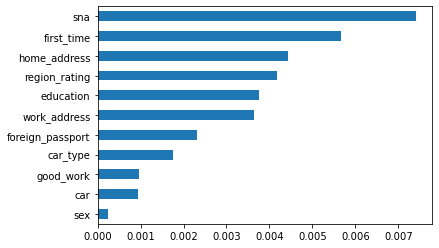

In [260]:
#df[bin_cols + cat_cols] - это признаки
#df['default'] - это таргет
#discrete_features =True If bool, then determines whether to consider all features discrete or continuous.
#index = bin_cols + cat_cols - это чтобы выводились названия колонок
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Исходя из полученных значений для нечисловых признаков можно сделать вывод, что признаки sex, car, good_work, car_type не являются особо значимыми признаками. Будем помнить об этом и возможно избавимся от этих признаков в дальнейшем

# Стандартизация числовых признаков

Прежде чем мы выберем скейлер, еще раз посмотрим на числовые признаки и вспомним все их особенности

In [201]:
data[num_cols].head()

,age,decline_app_cnt,bki_request_cnt,income,score_bki
0,4.143135,0.000000,0.693147,9.798183,-2.008753
1,4.094345,0.000000,1.386294,9.852247,-1.532276
2,3.258097,1.098612,0.693147,10.308986,-1.408142
3,3.988984,0.000000,1.098612,9.210440,-2.057471
4,3.891820,0.000000,0.693147,10.308986,-1.244723


- У признака decline_app_cnt есть многочисленные выбросы, поэтому скейлер должен обладать устойчивостью к выбросам (Min-Max scaler не подходит, чувствителен к выбросам)
- Гауссово распределение (нормальное) только у признаков income (после логарифмирования) и score_bki (Standard Scaler не подходит, требует нормального распределения)
- Диапазоны значений у признаков не сильно различаются, то есть у всех признаков диапазон приблизительно от - 10 до 10.

По видимому, ничего не остается как использовать RobustScaler

Поскольку со всеми признаками результаты не очень хорошие, попробуем удалить часть незначимых признаков

In [42]:
# числовые переменные
num_cols = ['decline_app_cnt', 'bki_request_cnt', 'score_bki']

In [43]:
scaler = RobustScaler() 
X_num = scaler.fit_transform(data[num_cols].values)

# Подготовка данных к машинному обучению

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

Поскольку со всеми признаками результаты не очень хорошие, попробуем удалить часть незначимых признаков

In [44]:
bin_cols = ['foreign_passport']

In [45]:
# Объединяем
#Функция hstack() соединяет массивы по горизонтали. По своей сути такое соединение эквивалентно соединению массивов 
#вдоль второй (или первой, если считать от 0) оси. Одномерные массивы просто соединяются.
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

In [46]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Model 

## Параметры по умолчанию

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


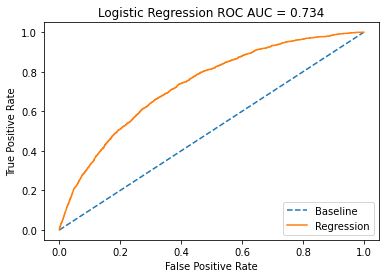

In [318]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Без подбора гиперпараметров значение на kaggle получилось 0.5

## Подбор гиперпараметров

In [47]:
# Добавим типы регуляризации
penalty = ['l1', 'l2', 'elasticnet']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)


# Зададим значения для солвера - не получилось сделать перебор, комп считал 4 часа и умер
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Зададим значения до кол-ва максимальных итераций
max_iter = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

class_weight = ['balanced', None]

multi_class = ['auto', 'ovr', 'multinomial']

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, solver=solver, max_iter=max_iter, class_weight=class_weight, multi_class=multi_class)
#hyperparameters = dict(C=C, penalty=penalty, max_iter=max_iter)
#hyperparameters = dict(C=C, penalty=penalty, solver=solver)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
#указываем модель (в нашем случае лог регрессия), гиперпараметры
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Лучшее class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Лучшее multi_class:', best_model.best_estimator_.get_params()['multi_class'])

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: Fi

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWa

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solv

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticne

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver liblinear does not support a multinomial backend.

  FitFailedWarning)
/Users/dariamishina/op

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not

/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dariamishina/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

KeyboardInterrupt: 

## Параметры полученные при подборе

Solver не удалось подобрать через GridSearchCV, по умолчанию значение lbfgs, попробуем newton-cg, liblinear, sag, saga по очереди и посмотрим, где будут лучше результаты

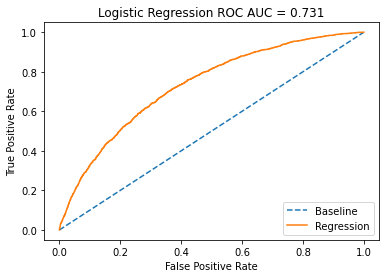

In [125]:
model = LogisticRegression(penalty='l2', C=7.742636826811269, solver ='saga', class_weight='balanced', max_iter=100, random_state=42)
model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

После запуска модели с подобранными гиперпараметрами значение для ROC AUC не изменилось, и значение на kaggle тоже. Попробуем убрать незначимые признаки

После удаления незначимых признаков ROC AUC стал меньше, но результат на kaggle улучшился с 0.5 до 0.55045

Перебор вариантов для solver руками newton-cg, liblinear, sag, saga ничего не дал, на kaggle такой же результат 0.55045 как со значением по умолчанию lbfgs, ROC AUC стал меньше - без параметра solver

при добавлении параметра class_weight='balanced' значение на kaggle улучшилось до 0.652739, ROC AUC  вырос незначительно. При добавлении параметра solver ='saga' результат на kaggle улучшился до 0.65287 

## LogisticRegressionCV

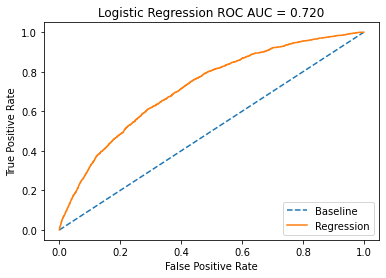

In [401]:
clf = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
#predict_proba - Probability estimates.
probs = clf.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

результат на kaggle не улучшился

# Submission

Убираем признак, ктр не включили в модель: app_date

In [96]:
true_test.drop(['app_date'], axis = 1, inplace=True)

In [95]:
#data = pd.read_csv(
    #'C:/Users/DariaMishina/skillfactory_rds/module_4/train.csv')
true_test = pd.read_csv(
    'C:/Users/DariaMishina/skillfactory_rds/module_4/test.csv')
#sample_submission = pd.read_csv(
    #'C:/Users/DariaMishina/skillfactory_rds/module_4/sample_submission.csv')

Проверим, что получилось

In [291]:
true_test.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
19691,16558,SCH,M,54,N,N,0,0,-1.899816,3,50,1,2,47000,1,4,N
17913,13813,PGR,M,53,Y,N,2,0,-2.338697,2,40,2,3,55000,1,3,N
28382,20892,SCH,F,39,N,N,1,0,-1.072601,0,50,1,3,28000,3,1,N
8682,19222,GRD,M,47,N,N,0,0,-1.469498,0,40,2,3,82000,1,3,N
25703,54208,SCH,M,30,Y,Y,0,0,-2.158390,1,50,1,1,40000,2,1,N


In [292]:
true_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   education         36178 non-null  object 
 2   sex               36349 non-null  object 
 3   age               36349 non-null  int64  
 4   car               36349 non-null  object 
 5   car_type          36349 non-null  object 
 6   decline_app_cnt   36349 non-null  int64  
 7   good_work         36349 non-null  int64  
 8   score_bki         36349 non-null  float64
 9   bki_request_cnt   36349 non-null  int64  
 10  region_rating     36349 non-null  int64  
 11  home_address      36349 non-null  int64  
 12  work_address      36349 non-null  int64  
 13  income            36349 non-null  int64  
 14  sna               36349 non-null  int64  
 15  first_time        36349 non-null  int64  
 16  foreign_passport  36349 non-null  object

Опять есть пропуски в признаке education, заполним их также модой

In [97]:
true_test['education'] = true_test['education'].fillna(true_test['education'].mode()[0])

Применяем наш скейлер к числовым признакам в тестовом файле

In [98]:
X_num_test = scaler.transform(true_test[num_cols].values)

Кодируем категориальные признаки

In [99]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(true_test[cat_cols].values)

Кодируем бинарные признаки

In [100]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    true_test[column] = label_encoder.fit_transform(true_test[column])
    
# убедимся в преобразовании    
true_test.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,0
1,17527,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,0
2,75683,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,1
3,26883,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,0
4,28862,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,0


Объединяем все наши перекодировки и признаки после скейлера

In [101]:
upd_true_test = np.hstack([X_num_test, true_test[bin_cols].values, X_cat_test])

In [288]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


предсказываем 

In [126]:
predict_submission = model.predict(upd_true_test)
#для LogisticRegressionCV
#predict_submission = clf.predict(upd_true_test)

добавляем полученные значения таргета default в тестовый файл

In [127]:
true_test['default'] = predict_submission

делаем файл из 2х колонок 

In [128]:
submission = true_test[['client_id', 'default']]

In [129]:
submission.to_csv('submission.csv', index=False)
submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0
